Found 6563 validated image filenames belonging to 38 classes.
Found 2188 validated image filenames belonging to 38 classes.
Found 10547 validated image filenames belonging to 38 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.1168 - loss: 7.2003 - val_accuracy: 0.1088 - val_loss: 3.5419
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 166s 805ms/step - accuracy: 0.2115 - loss: 6.7550 - val_accuracy: 0.1005 - val_loss: 3.4995
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 166s 804ms/step - accuracy: 0.2341 - loss: 6.4548 - val_accuracy: 0.2048 - val_loss: 3.3166
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 166s 805ms/step - accuracy: 0.2292 - loss: 6.1051 - val_accuracy: 0.2290 - val_loss: 3.2133
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 166s 805ms/step - accuracy: 0.2358 - loss: 5.7502 - val_accuracy: 0.0772 - val_loss: 3.4225
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 166s 805ms/step - accuracy: 0.2443 - loss: 5.6791 - val_accuracy: 0.2436 - val_loss: 3.1122
Epoch 7/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 166s 804ms/step - accuracy: 0.2428 - loss: 5.4117 - val_accuracy: 0.2527 - val_loss: 3.0237
Epoch 8/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 166s 804ms/step - accuracy: 0.2502 - loss: 5.2760 

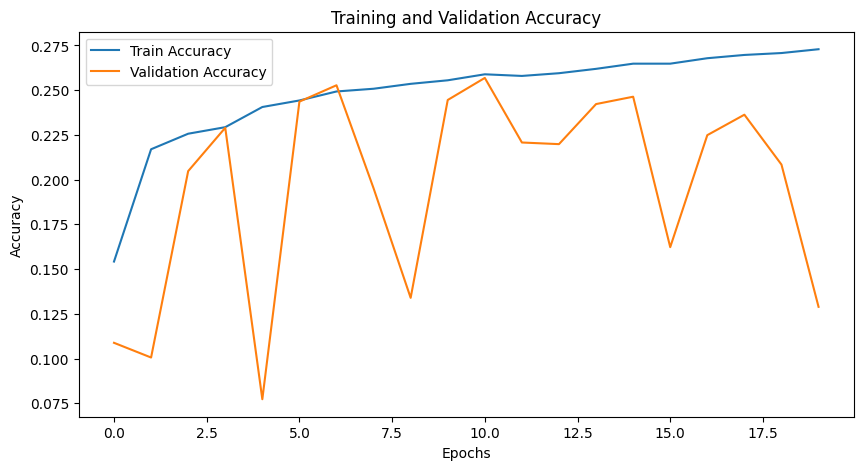

330/330 ━━━━━━━━━━━━━━━━━━━━ 71s 211ms/step


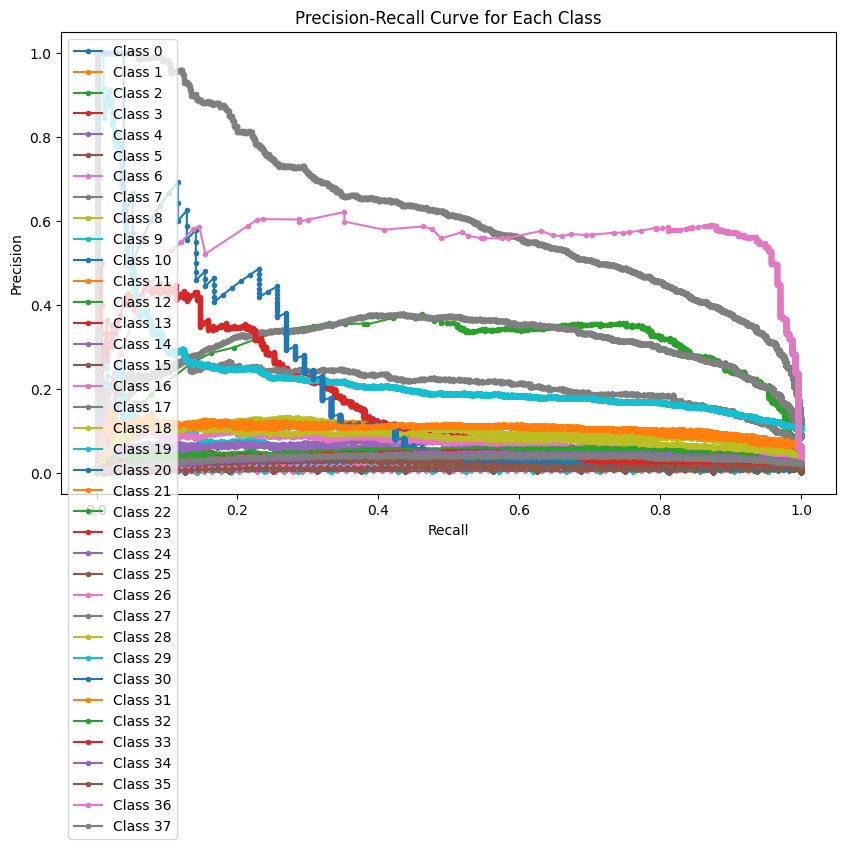

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve

# Set dataset paths
dataset_path = "/kaggle/input/plant-village"

# Load dataset and split into Train/Validation/Test
all_images, all_labels = [], []
label_map = {str(i): i for i in range(38)}

# Collect images and labels from the train folder
train_folder = os.path.join(dataset_path, "train/train")
for label in os.listdir(train_folder):
    label_path = os.path.join(train_folder, label)
    for img_file in os.listdir(label_path):
        all_images.append(os.path.join(label_path, img_file))
        all_labels.append(label_map[label])

# Split train into 75% training and 25% validation
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

# Collect images and labels from the test folder (keep as is)
test_imgs, test_labels = [], []
test_folder = os.path.join(dataset_path, "test/test")
for label in os.listdir(test_folder):
    label_path = os.path.join(test_folder, label)
    for img_file in os.listdir(label_path):
        test_imgs.append(os.path.join(label_path, img_file))
        test_labels.append(label_map[label])

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

datagen = ImageDataGenerator(rescale=1.0/255)
train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_imgs, "class": train_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse")
val_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": val_imgs, "class": val_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse")
test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_imgs, "class": test_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse", shuffle=False)

# Define U-Net model
def unet_model(input_size=(224, 224, 3), num_classes=38):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)
    gap = GlobalAveragePooling2D()(conv10)
    output = Dense(num_classes, activation='softmax')(gap)

    model = Model(inputs, output)
    return model

model = unet_model(input_size=(224, 224, 3), num_classes=38)
model.compile(optimizer=Adam(learning_rate=0.0007), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(train_gen, validation_data=val_gen, epochs=20, class_weight=class_weight_dict)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_gen)
print("Final Test Accuracy:", test_accuracy)

# Plot training/validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Compute and plot PR curve
y_true = tf.keras.utils.to_categorical(test_gen.classes, 38)
y_probs = model.predict(test_gen)

plt.figure(figsize=(10, 6))
for i in range(38):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()